In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
#import graphviz

In [2]:
#abundance = pd.read_csv("TCGA_Poore/Kraken/Kraken-TCGA-Voom-SNM-Full-Data.csv", index_col=0)
abundance = pd.read_csv("TCGA_Poore/Kraken/Kraken-TCGA-Voom-SNM-All-Putative-Contaminants-Removed-Data.csv", index_col=0)
abundance = abundance[abundance.sum(axis = 1) > 0]
abundance = abundance.dropna()
print(abundance.shape)

(17625, 1411)


In [3]:
abundance

,k__Viruses.f__Phycodnaviridae.g__Prasinovirus,k__Viruses.o__Caudovirales.f__Siphoviridae.g__Sfi1unalikevirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Simplexvirus,k__Viruses.f__Poxviridae.g__Parapoxvirus,k__Viruses.f__Bicaudaviridae.g__Bicaudavirus,k__Viruses.o__Picornavirales.f__Picornaviridae.g__Aquamavirus,k__Viruses.o__Herpesvirales.f__Herpesviridae.g__Mardivirus,k__Viruses.f__Baculoviridae.g__Deltabaculovirus,k__Viruses.f__Papillomaviridae.g__Taupapillomavirus,k__Viruses.o__Caudovirales.f__Myoviridae.g__I3likevirus,...,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Clostridiales_Family_XIII._Incertae_Sedis.g__Casaltella,k__Bacteria.p__Proteobacteria.c__Betaproteobacteria.o__Neisseriales.f__Chromobacteriaceae.g__Deefgea,k__Bacteria.p__Proteobacteria.c__Alphaproteobacteria.o__Rhizobiales.f__Phyllobacteriaceae.g__Aquamicrobium,k__Bacteria.p__Deferribacteres.c__Deferribacteres.o__Deferribacterales.f__Deferribacteraceae.g__Geovibrio,k__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridiales.f__Ruminococcaceae.g__Subdoligranulum,contaminant1Harvard,contaminant2HarvardCanadaBaylorWashU,contaminant3AllSeqCenters,contaminant4RandomSpikesHarvard,contaminant5RandomSpikes1000
s17489,-0.944325,1.378696,4.257198,2.263261,0.478455,3.283590,6.175448,0.554111,1.707182,-2.701144,...,2.952431,1.053012,1.641701,1.597915,1.615110,1.613142,12.579647,12.579647,1.579534,2.482244
s17512,2.799427,2.095355,5.282909,0.625737,1.262373,2.598059,5.032088,-0.978710,-0.066234,0.042982,...,3.623247,2.048703,2.357091,2.339657,2.378702,2.338944,13.305450,13.305450,2.332050,2.855626
s17498,-0.350754,1.969313,4.789957,0.645980,1.072432,2.454999,6.929492,-1.045204,4.299620,0.037454,...,3.531484,1.879986,2.273343,2.176359,2.268394,2.254124,13.220630,13.220630,2.211553,3.193130
s17528,2.163915,1.915785,4.830879,0.699582,1.110310,0.812846,5.856873,1.314613,2.308325,1.252654,...,3.649382,1.827052,2.385817,2.223181,2.313300,2.361125,13.327630,13.327630,2.164692,3.090736
s17535,0.053629,2.127427,3.664010,0.911225,1.321953,3.560542,6.068515,-0.795673,0.198039,-1.705629,...,3.861024,2.038694,2.597460,2.434824,2.524942,2.572767,13.539273,13.539273,2.376335,3.302378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s23,0.284636,2.194480,4.703390,0.814588,1.239996,1.451831,7.643768,-0.498119,3.479699,-1.214270,...,3.606118,2.043599,2.325969,2.347134,2.320139,2.292332,13.258838,13.258838,2.259281,3.443482
s20,0.459102,2.421001,4.873527,1.102422,1.471217,1.771189,3.612937,-0.324706,1.182912,-1.272753,...,3.855399,2.293863,2.546157,2.490664,2.572189,2.545829,13.512334,13.512334,2.537966,3.876017
s27,2.354685,2.152569,3.585112,0.904770,1.340790,1.417062,7.595169,-0.405086,0.796029,-1.078900,...,3.627826,2.068357,2.344308,2.365683,2.353494,2.348888,13.315394,13.315394,2.232305,3.625496
s26,0.352523,2.472335,4.215219,1.224536,1.660556,1.736829,7.021851,-0.085319,1.115795,-0.759133,...,3.947592,2.388124,2.664075,2.685449,2.673261,2.668655,13.635160,13.635160,2.552071,3.945263


In [4]:
abundance_df = pd.DataFrame(abundance)

# Define a list of invalid names: no information or virus are invalid
invalid_names = ['f__.g__.s__','g__.s__','virus']

# Iterate over columns and drop those containing invalid names
for col in abundance_df.columns:
    if any(invalid_name in col for invalid_name in invalid_names):
        abundance_df.drop(col, axis=1, inplace=True)

# Extract family, genera, and species from existing column names
def extract_taxonomy(column):
    return '; '.join([t for t in column.split('.') if t.startswith('f__') or t.startswith('g__') or t.startswith('s__')])

# Create new column names
new_columns = [extract_taxonomy(column) for column in abundance_df.columns]

# Rename columns
abundance_df.columns = new_columns

abundance_df

,f__Halomonadaceae; g__Cobetia,f__Thermoanaerobacteraceae; g__Ammonifex,f__Cryomorphaceae; g__Owenweeksia,f__Haloplasmataceae; g__Haloplasma,f__Desulfobacteraceae; g__Desulfosarcina,f__Enterobacteriaceae; g__Siccibacter,f__Acetobacteraceae; g__Asaia,f__Rhodobiaceae; g__Parvibaculum,g__Neosynechococcus,f__Sphingomonadaceae; g__Zymomonas,...,f__Clostridiales_Family_XIII; g__Casaltella,f__Chromobacteriaceae; g__Deefgea,f__Phyllobacteriaceae; g__Aquamicrobium,f__Deferribacteraceae; g__Geovibrio,f__Ruminococcaceae; g__Subdoligranulum,,,,,
s17489,0.750758,1.698080,1.211822,2.098064,1.901532,0.746481,-0.731171,0.069450,1.183112,0.950821,...,2.952431,1.053012,1.641701,1.597915,1.615110,1.613142,12.579647,12.579647,1.579534,2.482244
s17512,2.957832,2.437834,1.979203,0.569559,1.184304,1.657705,0.251591,2.690162,2.091016,-0.634765,...,3.623247,2.048703,2.357091,2.339657,2.378702,2.338944,13.305450,13.305450,2.332050,2.855626
s17498,2.865233,2.223742,1.849716,0.408622,2.003357,1.461779,1.840733,0.527662,1.917301,1.279785,...,3.531484,1.879986,2.273343,2.176359,2.268394,2.254124,13.220630,13.220630,2.211553,3.193130
s17528,1.331853,2.394651,1.813642,0.501072,0.985425,3.488439,4.899925,2.730293,1.865934,1.824556,...,3.649382,1.827052,2.385817,2.223181,2.313300,2.361125,13.327630,13.327630,2.164692,3.090736
s17535,-0.041467,2.606293,2.025285,2.297677,-0.041719,1.378154,2.874528,0.620008,2.077577,-0.771157,...,3.861024,2.038694,2.597460,2.434824,2.524942,2.572767,13.539273,13.539273,2.376335,3.302378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s23,1.492351,2.495612,2.118032,0.773989,0.951887,2.135941,3.213407,1.754071,2.045186,-0.399423,...,3.606118,2.043599,2.325969,2.347134,2.320139,2.292332,13.258838,13.258838,2.259281,3.443482
s20,1.642807,2.709255,2.253808,1.035752,2.675408,2.310780,1.919476,1.929309,2.437095,-0.077439,...,3.855399,2.293863,2.546157,2.490664,2.572189,2.545829,13.512334,13.512334,2.537966,3.876017
s27,1.422109,2.568446,2.202434,0.955879,1.782572,2.043960,1.740752,1.762615,2.213836,-0.036487,...,3.627826,2.068357,2.344308,2.365683,2.353494,2.348888,13.315394,13.315394,2.232305,3.625496
s26,1.741875,2.888213,2.522201,1.275646,1.571824,2.363727,2.060519,2.082382,2.533603,0.283279,...,3.947592,2.388124,2.664075,2.685449,2.673261,2.668655,13.635160,13.635160,2.552071,3.945263


In [5]:
metadata = pd.read_csv('TCGA_Poore/Metadata-TCGA-All-18116-Samples.csv', index_col=0)
metadata = metadata[metadata['investigation'] == 'TCGA-COAD']
print(metadata)

                               gdc_file_uuid  \
s13008  5DCDB663-BC72-4928-970A-2C50103CF337   
s12994  5220B7B2-6F81-4C7F-BFB4-B523C2C30DDF   
s13005  95F7BD48-5E28-4892-BC8D-A6DEC3B02D70   
s12987  78F6E4E8-1349-43CB-AAA7-C56FD833DEDD   
s12895  D04CC01A-3CCB-4FC1-BAD8-2EDE20790454   
...                                      ...   
s13862  36293F9B-A284-467E-AB73-AE62FC5EAB6E   
s13849  86E4599E-AB45-4118-B105-32782288A0D3   
s13857  CCC44CA2-2E42-4083-9252-597D398BE401   
s13839  0DD44906-041D-4AF2-8F42-A1BED185E1C6   
s13842  7942EAB9-D80A-496E-B3CB-50B42BD23334   

                                                 filename  age_at_diagnosis  \
s13008  UNCID_340264.TCGA-AZ-4615-01A-01R-1410-07.1103...              84.0   
s12994  UNCID_269004.TCGA-AA-A02R-01A-01R-A00A-07.1008...              84.0   
s13005  UNCID_339870.TCGA-AA-3488-01A-01R-1410-07.1103...              58.0   
s12987  UNCID_269354.TCGA-AA-3815-01A-01R-1022-07.1008...              65.0   
s12895  UNCID_1590129.79b022

In [6]:
print(metadata.columns)

Index(['gdc_file_uuid', 'filename', 'age_at_diagnosis', 'aliquot_uuid',
       'case_uuid', 'days_to_death', 'disease_type', 'ethnicity',
       'experimental_strategy', 'gender', 'investigation', 'platform',
       'primary_site', 'race', 'reference_genome', 'sample_type',
       'sample_uuid', 'vital_status', 'tissue_source_site_label',
       'data_submitting_center_label', 'country_of_sample_procurement',
       'histological_diagnosis_label', 'pathologic_t_label',
       'pathologic_n_label', 'pathologic_stage_label', 'icd03_histology_label',
       'icd03_histology_site', 'icd10', 'portion_is_ffpe',
       'new_tumor_event_after_initial_trtmt',
       'primary_therapy_outcome_success_label', 'portion_weight',
       'aliquot_concentration', 'analyte_A260A280Ratio', 'analyte_amount',
       'analyte_type_label', 'radiation_therapy_code_label',
       'radiation_therapy_site_label', 'radiation_therapy_type_label',
       'year_of_diagnosis', 'vital_status_label'],
      dtype='obje

In [7]:
scaler = StandardScaler()

In [8]:
COAD = pd.merge(abundance_df, metadata, left_index=True, right_index=True)
COAD = COAD
#merged_df.head
COAD.shape
COAD


,f__Halomonadaceae; g__Cobetia,f__Thermoanaerobacteraceae; g__Ammonifex,f__Cryomorphaceae; g__Owenweeksia,f__Haloplasmataceae; g__Haloplasma,f__Desulfobacteraceae; g__Desulfosarcina,f__Enterobacteriaceae; g__Siccibacter,f__Acetobacteraceae; g__Asaia,f__Rhodobiaceae; g__Parvibaculum,g__Neosynechococcus,f__Sphingomonadaceae; g__Zymomonas,...,portion_weight,aliquot_concentration,analyte_A260A280Ratio,analyte_amount,analyte_type_label,radiation_therapy_code_label,radiation_therapy_site_label,radiation_therapy_type_label,year_of_diagnosis,vital_status_label
s13008,0.549996,3.627426,1.243335,0.200708,-0.019726,3.566605,1.143794,3.529965,1.626574,-0.920077,...,36.0,0.14,1.80,147.30,RNA,NaN,NaN,NaN,2009.0,Alive
s12994,1.036992,2.472233,1.813183,0.705863,-0.388531,1.471217,1.448203,1.290475,2.069139,-0.342958,...,110.0,0.15,1.72,132.38,RNA,NaN,NaN,NaN,2006.0,Dead
s13005,0.391081,4.148250,3.489199,0.059951,-1.034442,0.825306,2.387254,3.451919,3.745155,0.596093,...,137.0,0.17,1.80,583.30,RNA,NaN,NaN,NaN,2002.0,Dead
s12987,0.307795,1.743036,2.668948,-0.023334,-1.117728,0.742020,2.303968,0.561278,1.339942,-1.072154,...,158.0,0.14,1.80,438.30,RNA,NaN,NaN,NaN,2007.0,Alive
s12895,1.091898,2.527139,1.868089,2.345731,1.251338,1.526123,1.503109,1.345381,2.124045,-0.288051,...,114.0,0.13,1.80,533.30,RNA,NaN,NaN,NaN,2009.0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s13862,0.955064,2.390305,1.731255,0.623935,1.114504,1.389289,3.688203,1.208548,1.987211,-0.424885,...,110.0,0.15,1.73,239.76,RNA,NaN,NaN,NaN,2009.0,Alive
s13849,2.017887,1.819532,0.994857,4.463031,-1.705226,0.701323,0.955917,0.587535,1.494217,-1.100823,...,129.0,0.15,1.80,877.30,RNA,NaN,NaN,NaN,2009.0,Alive
s13857,3.343320,2.743249,2.314112,1.020499,3.378589,3.974225,1.981555,1.969840,2.411123,0.229642,...,36.0,0.14,1.70,19.80,RNA,951909FD-4B2B-4D3F-918A-34269D0A70FC,Primary Tumor Field,EXTERNAL BEAM,2008.0,Alive
s13839,1.289116,2.429583,3.706441,2.381846,1.259359,2.226014,1.631685,1.822473,2.084668,2.162532,...,30.0,0.14,2.03,80.04,DNA,NaN,NaN,NaN,2004.0,Alive


In [9]:
class_counts = COAD['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           825
Blood Derived Normal    109
Solid Tissue Normal      70
Metastatic                1
Recurrent Tumor           1
Name: count, dtype: int64


In [10]:
# Prepare features and target variable
X = COAD.drop(['gdc_file_uuid', 'filename', 'age_at_diagnosis', 'aliquot_uuid',
       'case_uuid', 'days_to_death', 'disease_type', 'ethnicity',
       'experimental_strategy', 'gender', 'investigation', 'platform',
       'primary_site', 'race', 'reference_genome', 'sample_type',
       'sample_uuid', 'vital_status', 'tissue_source_site_label',
       'data_submitting_center_label', 'country_of_sample_procurement',
       'histological_diagnosis_label', 'pathologic_t_label',
       'pathologic_n_label', 'pathologic_stage_label', 'icd03_histology_label',
       'icd03_histology_site', 'icd10', 'portion_is_ffpe',
       'new_tumor_event_after_initial_trtmt',
       'primary_therapy_outcome_success_label', 'portion_weight',
       'aliquot_concentration', 'analyte_A260A280Ratio', 'analyte_amount',
       'analyte_type_label', 'radiation_therapy_code_label',
       'radiation_therapy_site_label', 'radiation_therapy_type_label',
       'year_of_diagnosis', 'vital_status_label'], axis=1)
X_scaled = scaler.fit_transform(X)
X_scaled
y = COAD['sample_type']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))
unique_labels, label_counts = np.unique(y, return_counts=True)
min_count = np.min(label_counts)
minority_class_labels = unique_labels[label_counts == min_count]
print("Label of the minority class:", minority_class_labels)

Unique values of y: ['Blood Derived Normal' 'Metastatic' 'Primary Tumor' 'Recurrent Tumor'
 'Solid Tissue Normal']
Unique values of y: [0 1 2 3 4]
Label of the minority class: [1 3]


In [11]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)


(4125, 1273)
(4125,)


Best Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9878772795691833
Test Set Accuracy: 0.994345718901454


<Figure size 800x600 with 0 Axes>

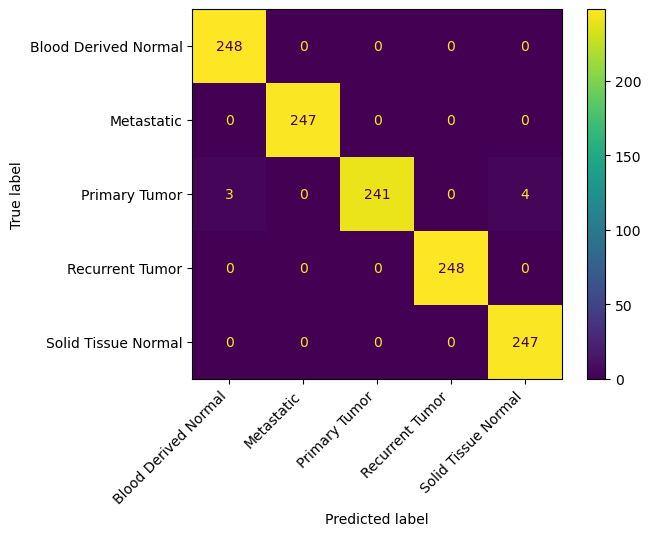

In [13]:
from sklearn.svm import SVC

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for SVM
params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
}

# Initialize SVM classifier
svm_model = SVC()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=svm_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

# Get the predicted labels
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blood Derived Normal', 'Metastatic', 'Primary Tumor', 'Recurrent Tumor',
 'Solid Tissue Normal'])
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
cm_display.plot()  # Plot confusion matrix
plt.xticks(rotation=45, ha='right')  # Rotate x-labels by 45 degrees
plt.show()

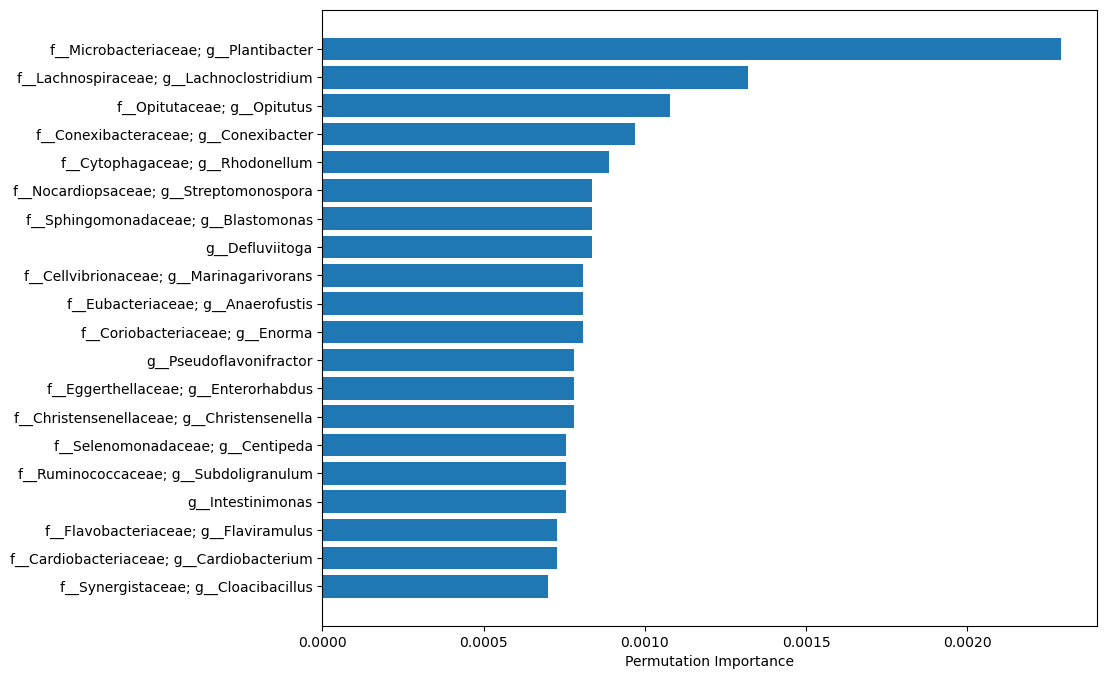

In [16]:
from sklearn.inspection import permutation_importance

# Get the permutation importance
perm_importance = permutation_importance(grid_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)

# Get the indices of the top 20 most important features
sorted_idx = perm_importance.importances_mean.argsort()[-20:]

original_feature_names = COAD.columns

# Plot the top 20 most important features
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [original_feature_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.show()

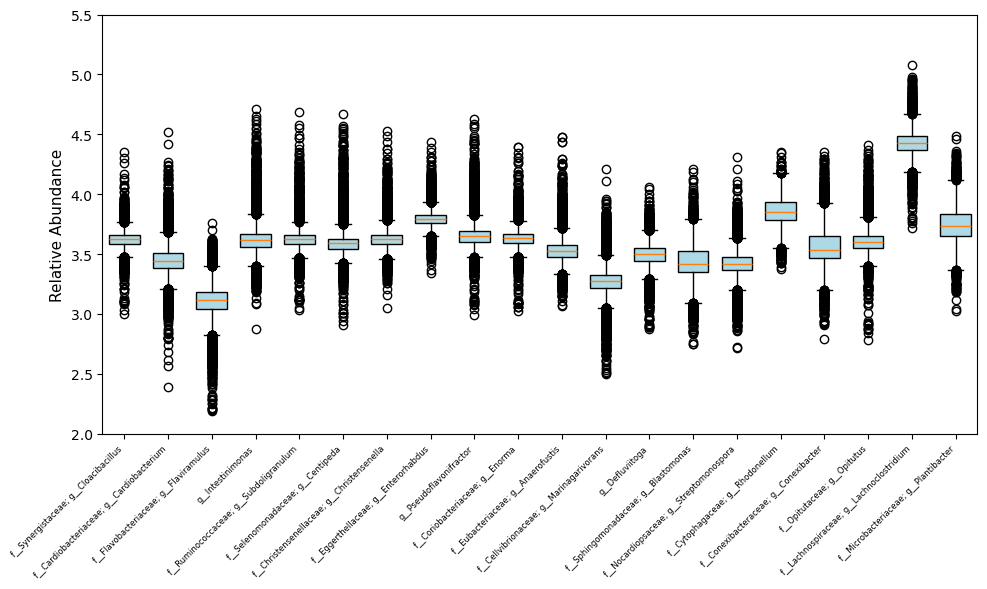

In [21]:
data = {}
top_20_feature_names = original_feature_names[sorted_idx]
abundance_scaled = np.log2(abundance_df + 10)

# Iterate over the columns of the DataFrame
for column_name in top_20_feature_names:
    data[column_name] = abundance_scaled[column_name]

plt.figure(figsize=(10, 6))
# Creating a box plot
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

plt.ylim(2, 5.5)
plt.ylabel('Relative Abundance', fontsize=11)

# Adding x-axis tick labels
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=45, ha='right', fontsize=6)  # Adjust fontsize here


# Displaying the plot
plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.show()